init scripts

In [2]:
import psycopg2
import random
import json
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import SparsePCA,PCA
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,precision_score,recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix


from sklearn import tree

In [3]:
def getdata(query):
    with open('config.json', 'r') as f:
        config_dict = json.load(f)
    #print(config_dict)
    #print(config_dict['password'])
    record = 0
    #string = "user=config_dict['user'] password = config_dict['password'] host = config_dict['host'] dbname = config_dict['dbname'] port = config_dict['port']"
    try:
        connection = psycopg2.connect(user=config_dict['user'],
                                      password=config_dict['password'],
                                      host=config_dict['host'],
                                      dbname=config_dict['dbname'],
                                      port=config_dict['port'])
        cursor = connection.cursor()
        # Print PostgreSQL Connection properties
        print ( connection.get_dsn_parameters(),"\n")
        # Print PostgreSQL version
        #cursor.execute("SELECT version();")
        cursor.execute(query)
        record = cursor.fetchall()
        #print("You are connected to - ", record,"\n")
    except (Exception, psycopg2.Error) as error :
        print ("Error while connecting to PostgreSQL", error)
    finally:
        #closing database connection.
            if(connection):
                cursor.close()
                connection.close()
                print("PostgreSQL connection is closed")
    return record;

umap and decision tree

In [4]:
import psycopg2
import json
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import umap
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#Get some data and make lists of embeddings with different values for neighbors and dimensions (components)
query_umap_totals = '''(SELECT TOP 10000
apikey_muvs,
total_engaged_time, months_since_user_signup, 
total_overview_views, total_search_views, 
total_export_actions, total_report_actions, 
total_detail_views, total_overlay_views, 
total_info_views, total_referrer_views,
total_author_views, total_section_views,  
total_tag_views, total_page_type_views,  
total_settings_views, total_campaign_group_actions, total_campaign_views,  
total_share_page_actions,  total_token_actions, did_return_visit 
   FROM visitors_by_month
   where did_return_visit = 0 
   ORDER BY RANDOM())
UNION ALL
(SELECT TOP 10000
apikey_muvs,
total_engaged_time,months_since_user_signup, 
total_overview_views, total_search_views, 
total_export_actions, total_report_actions, 
total_detail_views, total_overlay_views, 
total_info_views, total_referrer_views,
total_author_views, total_section_views,  
total_tag_views, total_page_type_views,  
total_settings_views, total_campaign_group_actions, total_campaign_views,  
total_share_page_actions,  total_token_actions, did_return_visit
   FROM visitors_by_month
   where did_return_visit = 1 
   ORDER BY RANDOM());'''
data_umap_totals = getdata(query_umap_totals)
data_umap_totals = [[data if data is not None else 0 for data in x_i] for x_i in data_umap_totals]
X_totals = [x_i[0:len(x_i)-1] for x_i in data_umap_totals]
y_totals = [x_i[-1] for x_i in data_umap_totals]

X_totals, X_test, y_totals, y_test = train_test_split(X_totals, y_totals, test_size = 0.1, random_state = 627)
X_train, X_valid, y_train, y_valid = train_test_split(X_totals, y_totals, test_size = 0.1, random_state = 627)
    

#for neighbors in [3,5,10,20,30,40,50]:
model = umap.UMAP(n_neighbors = 47, n_components = 20,verbose=1)
X_train = model.fit_transform(X = X_train) #, y = y_train);
print(X_train[0])

{'user': 'mlcalss', 'dbname': 'nydn', 'host': 'dbt-dpl-dev.c913t1mfbggj.us-east-1.redshift.amazonaws.com', 'port': '5439', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

PostgreSQL connection is closed
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=20, n_epochs=None,
     n_neighbors=47, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=1)
Construct fuzzy simplicial set
Thu Dec 12 21:47:35 2019 Finding Nearest Neighbors
Thu Dec 12 21:47:35 2019 Building RP forest with 11 trees
Thu Dec 12 21:47:36 2019 NN descent for 14 iterations
	 0  /  14
	 1  /  14
Thu De

In [25]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

newX_train = model.embedding_
newX_valid = model.transform(X_valid)

dtc = DecisionTreeClassifier(criterion='gini', 
                             splitter='best', 
                             max_depth=8)
dtc.fit(newX_train,y_train)
y_pred = dtc.predict(newX_valid)
print('confusion matrix', confusion_matrix(y_pred,y_valid))
print('accuracy',accuracy_score(y_pred,y_valid))
print('precision',precision_score(y_valid,y_pred))
print('recall',recall_score(y_valid,y_pred))

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
confusion matrix [[404 259]
 [520 617]]
accuracy 0.5672222222222222
precision 0.5426561125769569
recall 0.704337899543379


[ 1.9411060e+00 -2.1466119e+00  2.5198481e+00  2.3665714e+00
  1.9100534e+00 -3.3623440e+00 -5.6645846e+00 -1.3680716e-01
  3.8959856e+00 -7.4354997e+00 -2.1622109e+00 -7.4358764e+00
 -1.3636162e+00 -3.8350015e+00 -1.5006036e-01 -1.2088866e+01
 -1.4395100e+00  2.4588678e+00  2.6612377e+00  1.2879168e-03]
0 0


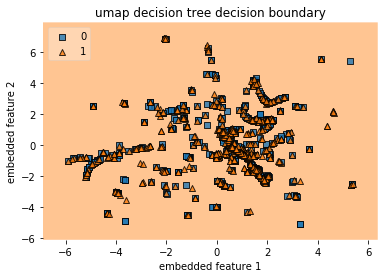

In [24]:
i = 2
print(newX_valid[i])
print(y_pred[i],y_valid[i])

from mlxtend.plotting import plot_decision_regions


value = 0
width = 100000000000.75


plot_decision_regions(newX_valid, np.array(y_valid), clf=dtc, 
                      filler_feature_values={2: value, 
                                             3: value,
                                             4: value,
                                             5: value,
                                             6: value,
                                             7: value,
                                             8: value,
                                             9: value,
                                             10: value,
                                             11: value,
                                             12: value,
                                             13: value,
                                             14: value,
                                             15: value,
                                             16: value,
                                             17: value,
                                             18: value,
                                             19: value},
                       filler_feature_ranges={2: width, 
                                              3: width,
                                              4: width,
                                              5: width,
                                              6: width,
                                              7: width,
                                              8: width,
                                              9: width,
                                              10: width,
                                              11: width,
                                              12: width,
                                              13: width,
                                              14: width,
                                              15: width,
                                              16: width,
                                              17: width,
                                              18: width,
                                              19: width},                  
                      legend=2)

plt.title('umap decision tree decision boundary')
plt.xlabel('embedded feature 1')
plt.ylabel('embedded feature 2')
plt.show()